# COGS 108 - Final Project 

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that PIDs will be scraped from the public submission, but student names will be included.)

* [  ] YES - make available
* [  ] NO - keep private

# Overview

*Fill in your overview here*

# Names

- Michael Baluja
- Griffin Mittleman
- Deepkiran Sangha
- Hannah Williams

# Group Members IDs

- A14499660
- A15734955
- A15096006
- A16112910

# Research Question

*Fill in your research question here*

## Background and Prior Work

*Fill in your background and prior work here* 

References (include links):
- 1)
- 2)

# Hypothesis


*Fill in your hypotheses here*

# Dataset(s)

Outline: (Delete before final submission!)
*Fill in your dataset information here*

(Copy this information for each dataset)
- Dataset Name:
- Link to the dataset:
- Number of observations:

1-2 sentences describing each dataset. 

If you plan to use multiple datasets, add 1-2 sentences about how you plan to combine these datasets.

Dataset 1:
- Dataset Name: Occupations by State and Likelihood of Automation
- Link to the dataset: https://data.world/wnedds/occupations-by-state-and-likelihood-of-automation
- Number of observations: 702 (1 per occupation)

This dataset includes job title, OCC code (used to categorize), probability of occupation, and number of employees per state

Dataset 2:
- Dataset Name: Wage by Occupation
- Link to the dataset: https://data.world/quanticdata/occupation-and-salary-by-state-and-likelihood-of-automation/workspace/file?filename=national_M2016_dl.xlsx
- Number of observations: 1394

This dataset includes job titles, OCC code, and various wage metrics per occupation (salary vs hourly, average pay, statistics for these fields, North American Industry Classification System code, employee number data, etc)

Dataset 3:
- Dataset Name: Employment by State
- Link to the dataset: https://www.bea.gov/data/employment/employment-by-state
- Number of observations: 51 (states + DC)

This dataset includes the number of employees present per state in any given year.

Dataset 4:
- Dataset Name: Employed persons by detailed occupation and age (table 11b)
- Link to the dataset:  https://www.bls.gov/cps/tables.htm
- Number of observations: 567

These datasets (collected for years between 2013 and 2019) show the number of employees per occupation by age group, and gives the total number of employees per occupation.

Datasets 1,2 provide information by occupations will be combined by their OCC code, since it is the most standard metric they share (note: some datasets have different occupation name string formatting, so this is not as easily used). Since we mostly want to consider this data in terms of probability of automation, data from Dataset 2 will only be kept if there is a corresponding OCC code in Dataset 1. Dataset 3 is used to turn the number of employees per occupation per state in Dataset 1 into fractions so we can look at relative numbers of employement as opposed to absolute numbers. 

The 7 datasets from Dataset 4 (corresponding to 2013-2019 data) will be combined in order to calculate the change in employment over the 7 year period. This data will be combined by Dataset 1 by OCC code in order to investigate the relationship between job field growth and likelihood of automation for that job field.

# Setup

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
import plotly.graph_objects as go
from scipy import stats
from copy import copy
from scipy.stats import normaltest

In [2]:
states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 
          'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois','Indiana', 'Iowa', 'Kansas', 
          'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 
          'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 
          'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 
          'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 
          'West Virginia', 'Wisconsin', 'Wyoming']

states_abbv = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 
               'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 
               'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 
               'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 
               'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']

# Data Cleaning

Describe your data cleaning steps here.

**How ‘clean’ is the data?**
Our data are clean in that they were provided by reputable sources who provided the data in a format without any unnecessary variables, null data, etc. For one of the datasets, some wage information was represented by a * or #, with the * meaning not enough data was available for inclusion, and the # meaning wage exceeded $200,000/yr

**What did you have to do to get the data into a usable format?**

Since some datasets were read in from excel datasheets, it was necessary to clean this data by removing the first few rows (title information), renaming the columns for proper identification, and resetting the index since the first n rows were removed. It was also necessary to remove additional columns that were not related to the dataframe, but were added for structural purposes in the excel datasheet.

Some dataframes required transposing/reshaping in order to more easily work with the data.


**What pre-processing steps were required for your methods?**

For our state analysis, it was necessary to transpose our data in the beginning, since the variables in the original dataset were now to be used as observations in this new dataset. An additional transformation was made to “normalize” the number of employees in each column by dividing them by the total number of workers per state.

We checked the distribution of variables such as probability of automation, wage, and employment percent change.

For the data in Datasets 4, we needed to drop all non-total employee rows and merge the 7 datasets into one set.

For the individual occupation wage analysis, it was necessary to drop most columns. We included occ code, annual mean wage, and occupation. The resulting dataset was merged with Dataset 1 by occ code so we could easily compare the likelihood of automation and the annual mean wage.


In [3]:
# Function tidy-izes the data
def organize(df, year):
    df = df[7:]
    df = df.rename(columns={df.columns[0]: 'Occupation', df.columns[1]: 'Total{}'.format(year)})
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df = df[['Occupation', 'Total{}'.format(year)]]

    
    return df

In [4]:
# Creating the pertinent DataFrames
df_prob = pd.read_csv('datasets/raw_state_automation_data.csv', encoding='cp1252')
df_employment = pd.read_excel('datasets/employmentbystate.xls')
df_wages = pd.read_excel('datasets/wagedata.xlsx')
unemployment = pd.read_csv('datasets/USunemployment.csv')
economyData = pd.read_csv('datasets/economy-and-growth-indicators-for-united-states-1.csv')
economyState = pd.read_csv('datasets/SAEMP25N__ALL_AREAS_1998_2018.csv')
income = pd.read_csv('datasets/PARPI_PORT_2008_2017.csv')

employment2011 = organize(pd.read_excel('datasets/blsdata/cpsaat11b2011.xlsx'), 2011)
employment2012 = organize(pd.read_excel('datasets/blsdata/cpsaat11b2012.xlsx'), 2012)
employment2013 = organize(pd.read_excel('datasets/blsdata/cpsaat11b2013.xlsx'), 2013)
employment2014 = organize(pd.read_excel('datasets/blsdata/cpsaat11b2014.xlsx'), 2014)
employment2015 = organize(pd.read_excel('datasets/blsdata/cpsaat11b2015.xlsx'), 2015)
employment2016 = organize(pd.read_excel('datasets/blsdata/cpsaat11b2016.xlsx'), 2016)
employment2017 = organize(pd.read_excel('datasets/blsdata/cpsaat11b2017.xlsx'), 2017)
employment2018 = organize(pd.read_excel('datasets/blsdata/cpsaat11b2018.xlsx'), 2018)
employment2019 = organize(pd.read_excel('datasets/blsdata/cpsaat11b2019.xlsx'), 2019)

employment = pd.merge(pd.merge(employment2011, employment2012), \
                      pd.merge(pd.merge(employment2013, pd.merge(employment2014, employment2015)), \
                               pd.merge(pd.merge(employment2016, employment2017), \
                                        pd.merge(employment2018, employment2019))))

In [5]:
## Cleaning - occ_by_state
# Structure main dataset
df_prob.sort_values(by=['SOC'], inplace=True)

# Standardize Occupation column between datasets
employment['Occupation'] = employment['Occupation'].apply(lambda x: x.title())
df_prob['Occupation'] = df_prob['Occupation'].apply(lambda x: x.title())

# Create trimmed dataset
df_prob_trim = df_prob[['SOC', 'Occupation', 'Probability']]

# Include employment info
df_prob_trim = pd.merge(df_prob_trim, employment)

# Add percent change based on 2013 to 2019 data
df_prob_trim['percent_change'] = (df_prob_trim.Total2019 - df_prob_trim.Total2013)/df_prob_trim.Total2013

In [6]:
## Cleaning - wageanalysis
#Remove unnecessary wage data
df_wages = df_wages[['OCC_CODE', 'OCC_TITLE', 'A_MEAN']]
df_wages.rename(columns={'OCC_CODE':'SOC', 'OCC_TITLE':'Occupation'},inplace=True)

# Create combined probability & wages dataset
df_probwages = pd.merge(df_prob, df_wages, how='left', left_on='SOC', right_on='SOC')

# Drop rows if no mean wage info
# * is used to represent occupation with insufficient data
df_probwages = df_probwages[df_probwages.A_MEAN != '*']

# Remove any null income values
df_probwages.dropna(inplace=True,subset=['A_MEAN'])
df_probwages = df_probwages.reset_index()

# Rest of values should be numeric, so transform
df_probwages.A_MEAN = pd.to_numeric(df_probwages.A_MEAN)

# Add log mean income 
df_probwages['log_A_MEAN'] = df_probwages.A_MEAN.apply(np.log)

In [7]:
## Cleaning - state_analysis
# Clean employment data
df_employment = df_employment[5:]
df_employment.dropna(inplace=True)
df_employment = df_employment.rename(columns={df_employment.columns[1]:'State', df_employment.columns[2]:'Employment'})
df_employment.reset_index(inplace=True)
df_employment = df_employment[['State', 'Employment']]
df_employment.Employment = df_employment.Employment.astype(int)

# Reshape data to easily apply later transformation
df_employment = df_employment.transpose()
df_employment.columns = df_employment.iloc[0]
df_employment = df_employment.iloc[1:]

# Transform employment data to reflect employment relative to population
df_prob_normed = copy(df_prob)
for state in states:
    df_prob_normed[state] = df_prob_normed[state].apply(lambda x: x/df_employment[state])

# Don't need SOC values, so remove
#df_prob.drop(columns=['SOC'],inplace=True)

In [8]:
income = income[['GeoName', 'LineCode','2008', '2009', '2010', '2011', '2012', '2013', '2014' , '2015', '2016', '2017']]
income = income[income.LineCode == 1.0]
income = income.loc[income.index > 0]

In [9]:
income = income.reset_index()
income = income.drop('index', 1)

In [13]:
N = 2
totalIn = income.groupby(income.index // N).sum()


In [14]:
totalIn['change'] = totalIn['2017'] - totalIn['2008']
totalIn['change'] = totalIn['change'] / totalIn['2008']

# Data Analysis & Results

## Employment Analysis

### EDA

**Distributions**

Our probability of automation variable is bound between 0-1 with a bimodal distribution. The peaks occur at the two boundaries. While the left boundary has a higher peak, the right mode carries more weight.

Our variable representing the percent change in employment between 2013 and 2019 follows a relatively normal unimodal distribution with few mini-peaks that do not change the shape drastically. This distribution is slightly right-skewed.

**Outliers**

While there is a relatively smooth distribution outside of the boundary peaks, there is a non-modal peak in the 0.35-0.40 probability bin.

There is a percent change outlier right around 4 (400% percent change). This corresponds to Transit And Railroad Police, which grew from 1,000 to 5,000 employees.

**Relationship between variables**

There is a very poor (horizontal) linear relation between the probability of automation and change in employment between 2013 and 2019. There is a stronger linear relationship between log annual income and probability of automation.

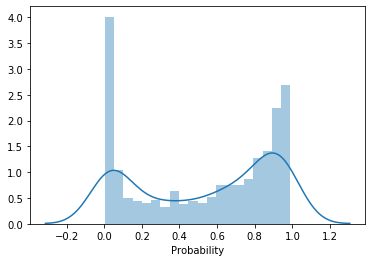

In [15]:
# Distribution of probability of automation
sns.distplot(df_prob.Probability, bins=20)

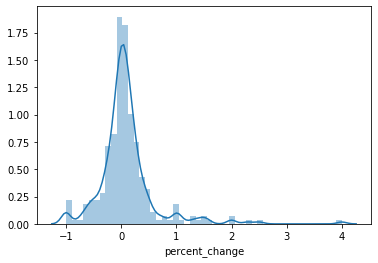

In [16]:
# Distribution of percent change in employment
sns.distplot(df_prob_trim.percent_change)

In [17]:
# Investigate outlier
df_prob_trim[df_prob_trim.percent_change >= 3.5]

,SOC,Occupation,Probability,Total2011,Total2012,Total2013,Total2014,Total2015,Total2016,Total2017,Total2018,Total2019,percent_change
121,33-3052,Transit And Railroad Police,0.57,8,3,1,3,1,2,7,2,5,4


In [18]:
# Determine normality of percent_change
k2, p = stats.normaltest(df_prob_trim.percent_change)
print(p)

7.761901649323115e-42


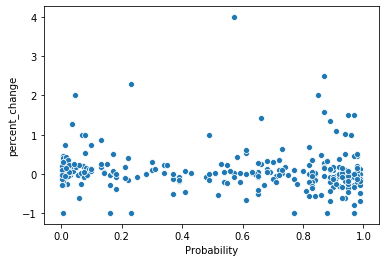

In [19]:
# Plot the percent change vs Probability of employment
sns.scatterplot(df_prob_trim.Probability, df_prob_trim.percent_change)

### Analysis

**What approaches did you use? Why?**

We analyze the relationship between percent change in employment and probability of automation using an OLS Linear Regression model. This method of analysis was chosen because there is a relatively linear relationship between the two variables.

**What were the results?**

The results from our analysis of the relationship between percent change in employment and the probability of automation shows inconclusive results. Due to the bimodal distribution of the probability of automation, our data was not properly distributed for this type of regression. Further attempts to normalize the data did not prove to be successful.

**What were your interpretation of these findings?**

Although the findings from the relation between employment percent change and automation did not prove to be conclusive of anything, we initially interpreted these results to show that the likelihood (probability) of automation is a complex factor with many contributing factors, and as such, we could not analyze it solely by looking at one possible contributor. This led to a breadth of comparisons being done in order to better understand the likelihood of automation.

In [20]:
# Does this data mean anything?
# (Hint: No, it doesn't)

# NOTE: Data does not meet requirements necessary for testing linearity, but want to take a look 

outcome, predictors = patsy.dmatrices('Probability ~ percent_change', df_prob_trim)
model = sm.OLS(outcome, predictors)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Probability   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                 -0.061
Method:                 Least Squares   F-statistic:                    0.9333
Date:                Wed, 10 Jun 2020   Prob (F-statistic):              0.633
Time:                        08:51:54   Log-Likelihood:                 143.79
No. Observations:                 274   AIC:                             186.4
Df Residuals:                      37   BIC:                             1043.
Df Model:                         236                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

## Income Analysis

### EDA

**Distributions**

**Outliers**


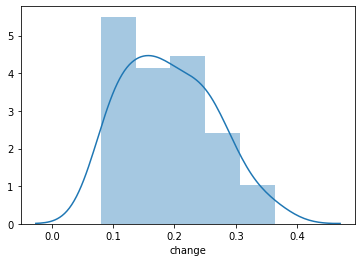

In [21]:
sns.distplot(totalIn.change)

# h

### Analysis

In [24]:
# Build composite likelihood of unemployment per state
state_likelihood = []
for state in states:
    likelihood = 0
    for index in range(len(df_prob)):
        likelihood += df_prob['Probability'][index] * df_prob[state][index]
    state_likelihood.append(likelihood)

list

In [27]:
statesDF = pd.DataFrame(states)
totalIncomeState = totalIn.merge(statesDF, left_index = True, right_index = True)
totalIncomeState = totalIncomeState.rename(columns={0: "State"})

In [28]:
likelihoodAutomation = pd.DataFrame(state_likelihood)
incomeANDautomation = likelihoodAutomation.merge(totalIncomeState, left_index=True, right_index=True)
incomeANDautomation = incomeANDautomation.rename(columns={0: "Automation"})
incomeANDautomation.head(3)

,Automation,LineCode,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,change,State
0,1101278.937,2.0,192040.7,189887.4,192990.2,196284.1,197375.7,197179.7,202594.2,210849.5,213127.5,216633.2,0.128059,Alabama
1,171255.766,2.0,32662.9,32757.8,34959.4,36690.7,37289.6,36679.0,37713.7,39171.7,38141.1,38209.2,0.169804,Alaska
2,1404832.153,2.0,236684.0,226100.0,229340.8,236651.0,244285.0,248772.8,261293.2,274505.2,283395.4,294477.6,0.244180,Arizona


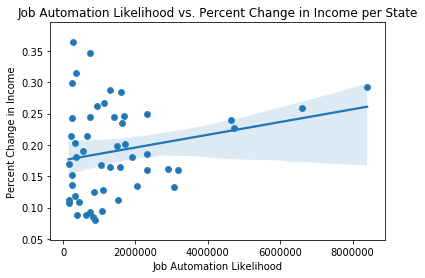

In [29]:
sns.scatterplot(incomeANDautomation.Automation, incomeANDautomation.change)
ax = sns.regplot(x="Automation", y="change", data=incomeANDautomation)
ax.set(title='Job Automation Likelihood vs. Percent Change in Income per State',xlabel='Job Automation Likelihood', ylabel='Percent Change in Income')
plt.show()

In [ ]:
outcome2, predictors2 = patsy.dmatrices('Automation ~ change', incomeANDautomation)
model2 = sm.OLS(outcome2, predictors2)
results2 = model2.fit()

print(results2.summary())

## Wage Analysis

### EDA

**Distributions**

Our annual mean wage variable takes a right-skewed normal distribution. We remove the skew by applying a natural log function to this data.

**Outliers**

There is an outlier in annual mean income around $225,000

In [ ]:
# Distribution of annual mean income
sns.distplot(df_probwages.A_MEAN)

In [ ]:
# Investigate mean annual income outlier
df_probwages[df_probwages.A_MEAN > 225000]

We see that these two extremely high paying outliers are both oral health occupations with a low probability of automation

In [ ]:
# Distribution of log annual mean income
sns.distplot(np.log(df_probwages.A_MEAN))

In [ ]:
# Test normality of log wage
stat_wage_mean_log, p_wage_mean_log = normaltest(df_probwages.log_A_MEAN)
print('log mean wage is normally distributed') if p_wage_mean_log < 0.01 else print('log mean wage is NOT normally distributed')

### Analysis

**What approaches did you use? Why?**

We analyze the relationship between log annual income and probability of automation by using an OLS Linear Regression model, because there is a clear linear relationship between these two variables.

**What were the results?**

The results from our analysis of the relationship between log annual income and the probability of automation provide a P|t| value of 0.000, with an Adjusted R^2 value of 0.330

**What were your interpretation of these findings?

We interpret the findings between log annual income and probability of income to support our initial hypothesis that lower paying jobs are more likely to suffer from job automation. Although our R^2 value is low from the OLS Regression we performed, our 0.000 p value shows that this data is at least conclusive. We believe that further analysis with additional variables can improve our adjusted R^2 value.

In [ ]:
# Regress 
outcome, predictors = patsy.dmatrices('Probability ~ log_A_MEAN', df_probwages)
model = sm.OLS(outcome, predictors)
results = model.fit()

print(results.summary())

In [ ]:
# Look at ditribution of probability and log annual income
sns.scatterplot(df_probwages.Probability, df_probwages.log_A_MEAN)

## State Analysis

### Analysis

**What approaches did you use? Why?**

For analysing which jobs are most likely to most contribute to automation, we look at the total number of employees per occupation in each state, and take this as a percent of the total number of working employees in that state. That percentage is then multiplied by the probability of automation, and each state is summed across each occupation in that state. This gives the relative weighted likelihood of automation across each state. We further look at which occupation most contributes to this factor, and organize this data geospatially. We chose to analyze this data in this way because it gave a relative score that allows us to compare each state’s overall probability of automation, instead of having our data skewed by looking at absolute employment values. This method also gives insight on which jobs need further attention in our analyses.

**What were the results?**

The results from our analysis between likelihood of automation by state show that there are only five different jobs across all 50 states + DC (51 total “areas”) that are the state’s highest contributors towards job automation. These occupations include cashiers, retail workers, administrative assistants, food prep & service workers, and office clerical workers. For 40 out of the 51 areas we analyze, the highest contributing occupation are retail workers. This occupation has an average US wage of around $27,000, which is less than half of the average income for 2016 in which this data were collected, and falls below the first quartile for US workers. We also see that the lowest aggregate probability of automation is in DC, at 29.93\% total risk of automation. The highest contributor in DC is secretaries.

**What were your interpretation of these findings?**

We interpret the findings of our state-automation data to support our initial hypothesis that lower-paying jobs will be more susceptible to job automation than higher paying jobs would. Since this statistic is based on the number of employees per occupation, it is necessary to make the distinction that this metric looks at the probability of automation for the highest number of jobs. A job with 100 employees and a .99 probability of automation would have a lower metric than a job with 200 employees and a .99 probability of automation. It is also interesting to consider secretaries in DC. The secretary position is the highest paying occupation from the five highest-contributor occupations. We interpret this under the assumption that a secretary is a relatively common job in DC (with each of the many political positions, among others, requiring at least one secretary). This means that secretaries make up a significant amount of the jobs held in DC, but current technological advancements like digital assistants and phone screenings may soon be capable of automating this position.

In [ ]:
# Build composite likelihood of unemployment per state
state_likelihood = []
df_state_data = pd.DataFrame()
for state in states:
    likelihood = 0.0
    max_likelihood = 0.0
    for index in range(len(df_prob)):
        new_likelihood = df_prob['Probability'][index] * df_prob_normed[state][index]
        likelihood += new_likelihood
        if  new_likelihood > max_likelihood:
            max_likelihood = new_likelihood
            df_state_data[state] = (df_prob.Occupation[index], df_prob[state][index], df_prob.SOC[index])
         
    state_likelihood.append(likelihood)
    #print('state: {}\n\t {}'.format(state, likelihood))

In [ ]:
# Transform state data dataframe
df_state_data = df_state_data.transpose()
df_state_data.rename(columns={0:'Occupation', 1:'Number', 2:'SOC'},inplace=True)

In [ ]:
# Change datatype for number of employees
df_state_data.Number = df_state_data.Number.astype(str)

In [ ]:
for occupation in df_state_data.Occupation.unique():
    SOC = df_state_data[df_state_data.Occupation == occupation].SOC.unique()[0]
    wage = int(df_wages[df_wages.SOC == SOC].A_MEAN.values[0])
    n_states = len(df_state_data[df_state_data.Occupation == occupation])
    print('Occupation: {}\n   Wage: {}\n   Num States: {}'.format(occupation, wage, n_states))

From this we can see that an the most overwhelming amount of jobs that will be lost due to automation will occur to retail salespeople. (This analysis looks at the amount of people affected multiplied by the probability of automation)

### Data Visualization

In [ ]:
# Add text column for hover-info on map
df_state_data['text'] = df_state_data.index + '<br>' + \
'Most affected occupation: ' + df_state_data.Occupation + '<br>' + \
'Num employees of occupation in state: ' + df_state_data.Number

fig = go.Figure(data=go.Choropleth(
    locations=states_abbv, # Spatial coordinates
    z = state_likelihood, # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'blues',
    colorbar_title =  "Automation Probability",
    autocolorscale=False,
    text = df_state_data.text
))

fig.update_layout(
    title_text = 'Likelihood of Job Automation by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

# Ethics & Privacy

All of our datasets have been provided by publicly available sources such as data.world, The Bureau of Labor Statistics, or other US Government agencies. Since these data are being provided to the public, we anticipate no restrictions in using it for the purpose of this project. Additionally, no restrictions have been posted for the datasets we are accessing. Much of the data we are using is provided by state or federal governments, which is required by law to provide strong protection for the data that are available to the public. For the data sources that are not guaranteed to do this, we will provide privacy by anonymizing any potentially personal identifiable information. However, we do not anticipate this being an issue, as all the data collected are aggregates that don’t include any potentially personal identifiable information. Occupations with less than 1,000 employees in a certain state were removed from our data.

One of our dataset sources, data.world, consists of contributors of various backgrounds and experience levels. This increases the potential for bias, since there is no way of confirming whether the presentation of the data is biased towards fulfilling the contributor’s needs. The user has the option of viewing the contributor’s Kaggle profile and their LinkedIn profiles, but the amount of information that is provided to the user is controlled by the contributor themselves. If we utilize the provided information to confirm the legitimacy of the contributor’s data, we can decrease the chance of potential bias. For our other data source, data.gov, there is a smaller potential of bias given the fact that it is a government source. While we cannot assume that government sources are entirely free of bias, we can assume that it is more of a fair source than non-government sources. Government sources are supposed to be free of affiliation to political parties, which is why we can assume that the data presented has relatively low levels of bias.

A potential ethical concern we have considered is data misinformation/misinterpretation. If an individual comes across our analysis without the understanding that this data relies partly on probability instead of concrete metrics, and that this analysis was not conducted by professional Data Scientists, it might lead to the unnecessary spread of fear that one might lose their job to automation, or further contribute to data misinterpretation.

# Conclusion & Discussion

*Fill in your discussion information here*

# Team Contributions

*Specify who in your group worked on which parts of the project.*

Michael:
- Cleaning/eda/analysis/viz for employment analysis and state analysis + mean annual income portion of wage analysis
- Ethics & Privacy 
- Datasets 1-4